# Калибровка модели

<div align="justify"><b>Калибровка</b> – сопоставление прогнозируемых вероятностей модели с их истинными вероятностями.</div>


<div align="justify"><b>Калибровка</b>  (Модели PD) – мета-модель, предназначенная для корректировки прогноза основной модели в соответствии с актуальным уровнем дефолта (PIT – Point In Time) или уровнем дефолта за экономический цикл (TTC – Through The Cycle).</div>

# Калибровочная кривая

In [66]:
from datetime import datetime
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.calibration import CalibrationDisplay

plt.rcParams['axes.edgecolor'] = '#a1a1a1'
%matplotlib inline
%config InlineBackend.figure_format='retina'

Генерация датасета для классификации

In [74]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples = 1000, # количество сэмплов
    n_features = 20, # количество функций
    n_informative = 2, # количество информ. функций
    n_redundant = 10, # количество избыточных функций
    weights = [0.8, .2], # пропорции сэмплов для каждого класса
    random_state = 42 # генерация случайных чисел
)
    

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=500, random_state=42)

Обучение модели

In [75]:
model = LogisticRegressionCV(cv=5)
model.fit(X_train, y_train)

# Получение модельных оценок вероятности класса 1
pred_train = model.predict_proba(X_train)[:, 1]
pred_test = model.predict_proba(X_test)[:, 1]

Для того, чтобы получить кривую калибровки, можно использовать модуль
```python
from sklearn.calibration import calibration_curve
```

In [76]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
                                y_true=y_train,      # Реальные метки классов
                                y_prob=pred_train,   # Модельная вероятность
                                pos_label=1, 
                                n_bins=10,          # 
                                strategy='uniform'  # или 'quantile' - зависит от распределения вероятности
                            )

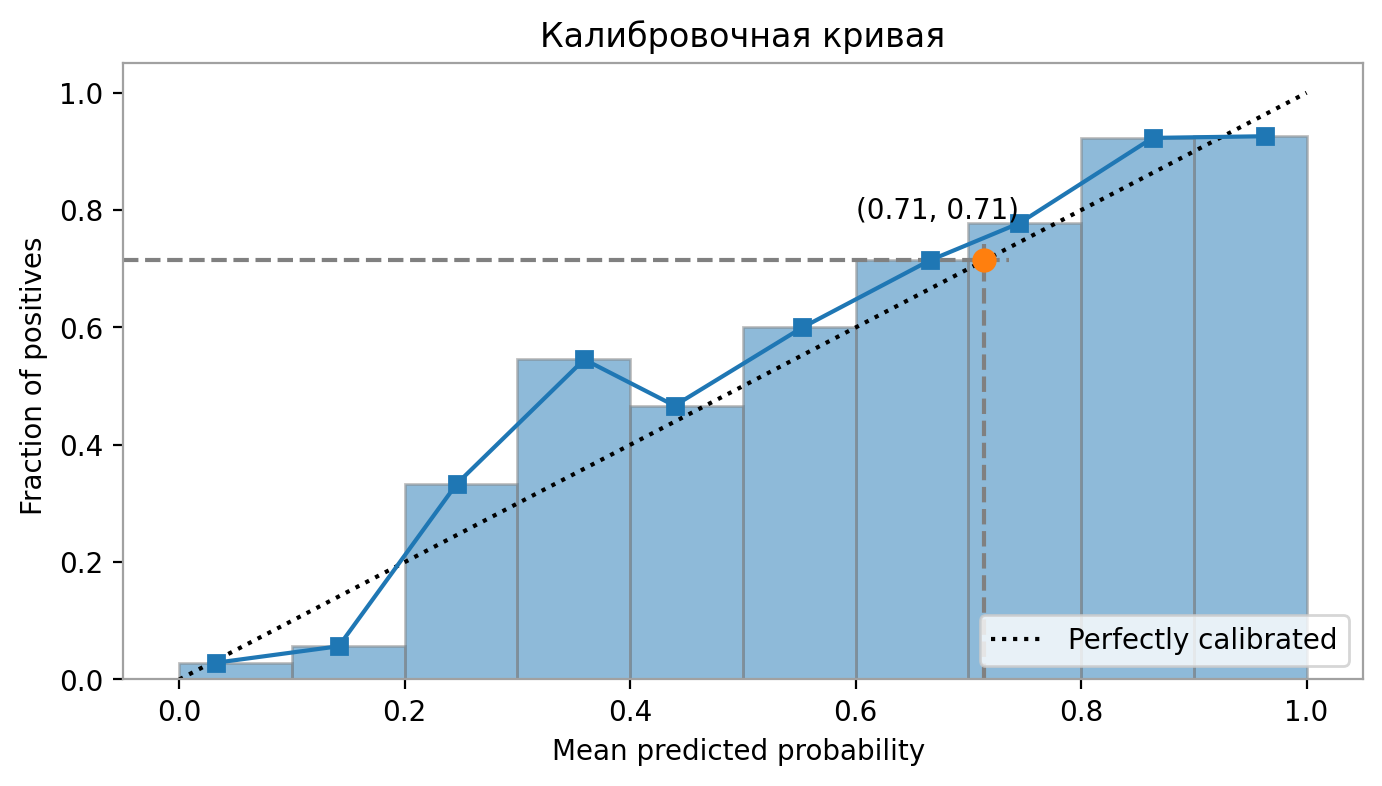

In [77]:
fig, ax = plt.subplots(1, figsize=(8, 4))

disp = CalibrationDisplay(prob_true, prob_pred, pred_train)

## ----------------------------------------------------------------------------------
plt.title("Калибровочная кривая")
plt.bar([- 0.05 + (0.1 * i) for i in range(1, 11)], 
        prob_true, 
        width=0.1, alpha=0.5, 
        align='center', 
        edgecolor='gray',
        color=None)

plt.axvline(prob_true[6], 0, prob_true[6], color='gray', linestyle='--')
plt.axhline(prob_true[6], 0, prob_true[6], color='gray', linestyle='--')
plt.scatter([prob_true[6]], [prob_true[6]], zorder=10, s=60)

plt.text(prob_true[5], prob_true[6]*1.1, f"({prob_true[6]:.2f}, {prob_true[6]:.2f})")
# plt.scatter(prob_pred, prob_pred)
## ----------------------------------------------------------------------------------

disp.plot(ax=ax)

## Причины низкой точности определения вероятности класса

### Причина №1. Архитектура модели 

In [35]:
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

lr = LogisticRegressionCV(cv=10, max_iter=1_000)
gnb = GaussianNB()
svc = SVC(probability=True)
rfc = RandomForestClassifier(random_state=42)

clf_list = [
    (lr, "Logistic Regression"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

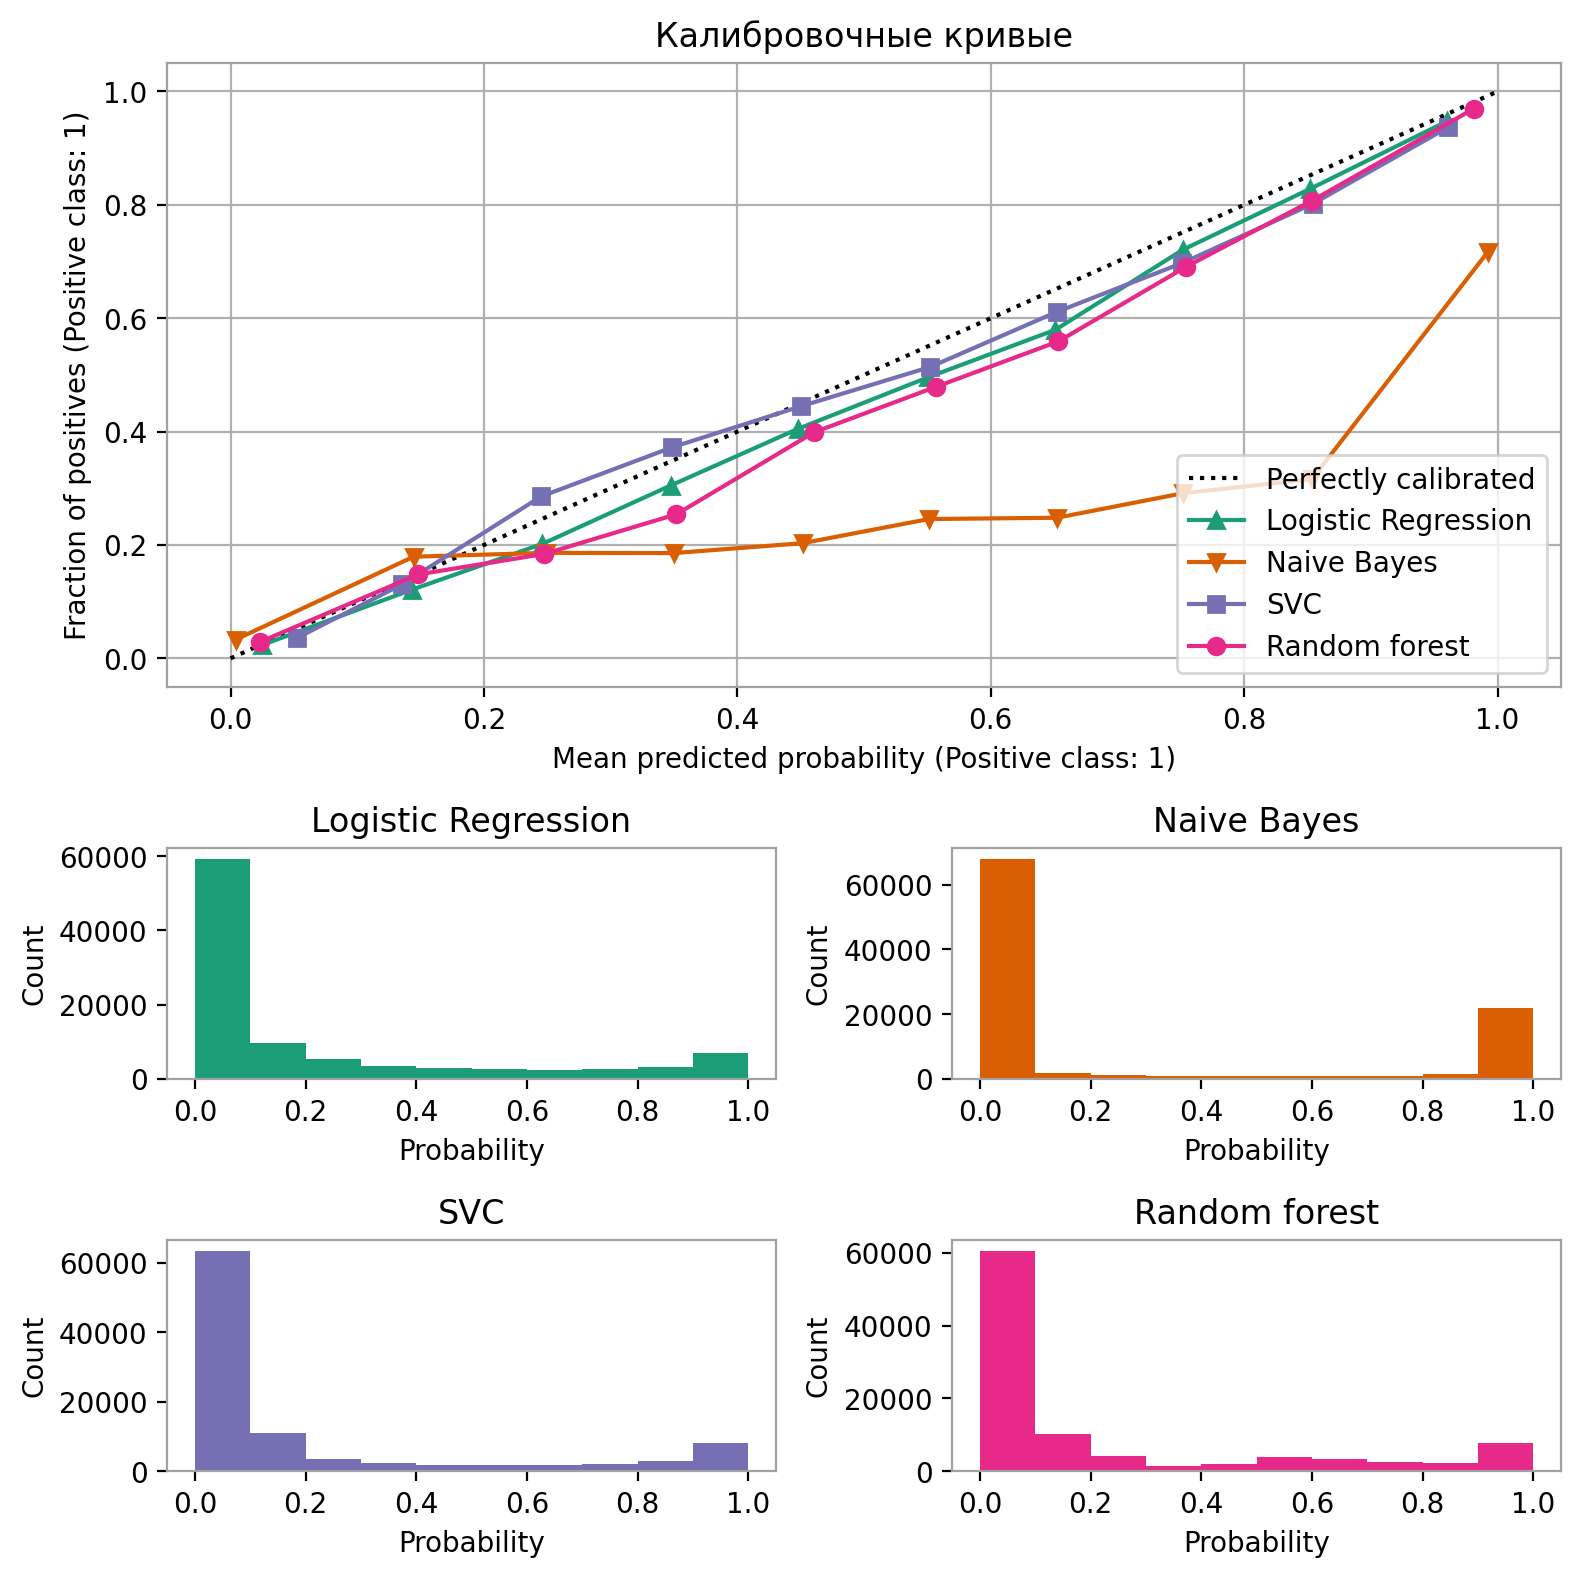

In [36]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 8))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Калибровочные кривые")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Probability", ylabel="Count")

plt.tight_layout()
plt.show()

`LogisticRegression` часто возвращает хорошо откалиброванные прогнозы по умолчанию, поскольку логистическая регрессия непосредственно оптимизирует логистическую функцию потерь. Напротив, другие методы возвращают смещенные вероятности, при этом степень смещения зависит от метода.

`Gaussian Bayes` имеет тенденцию сдвигать вероятности к 0 или 1
(обратите внимание на частоты в гистограммах). Это происходит
главным образом потому, что в нем делается предположение, что
признаки являются условно независимыми для данного класса, чего
нет в этом наборе данных, который содержит избыточные признаки.

`RandomForest` Такие методы, как бэггинг и случайные леса, которые усредняют прогнозы по набору базовых моделей, могут иметь трудности при прогнозировании 0 и 1, поскольку дисперсия, лежащая в основе базовых моделей, будет сдвигать прогнозы, близкие к нулю или единице, относительно этих значений. Поскольку прогнозы ограничены интервалом [0,1], ошибки, вызванные дисперсией, имеют тенденцию быть односторонними вблизи нуля и единицы. Например, если модель должна прогнозировать p = 0 для наблюдения, мы сможем получить такой прогноз в бэггинге лишь тогда, когда все деревья, построенные по бутстреп-выборкам, предсказывают 0

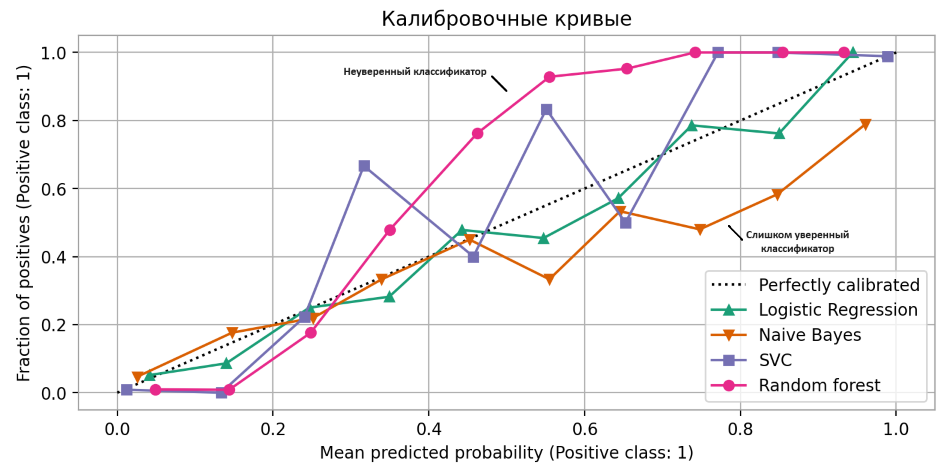

### Причина №2. Применение методов OverSampling и UnderSampling 

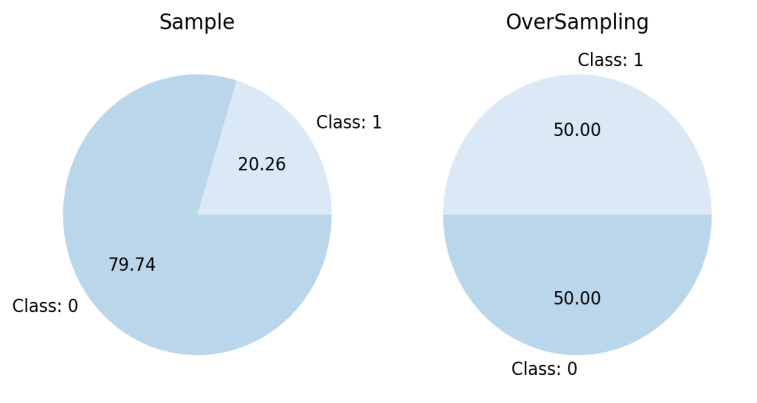

Применим OverSampling к нашим данным

In [78]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples = 10000, # количество сэмплов
    n_features = 20, # количество функций
    n_informative = 2, # количество информ. функций
    n_redundant = 10, # количество избыточных функций
    weights = [0.99, .01], # пропорции сэмплов для каждого класса
    random_state = 42 # генерация случайных чисел
)
    

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=2000, random_state=42)

In [81]:
# !pip install imblearn
from imblearn.over_sampling import RandomOverSampler

ovs = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ovs.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'Калибровочная кривая')

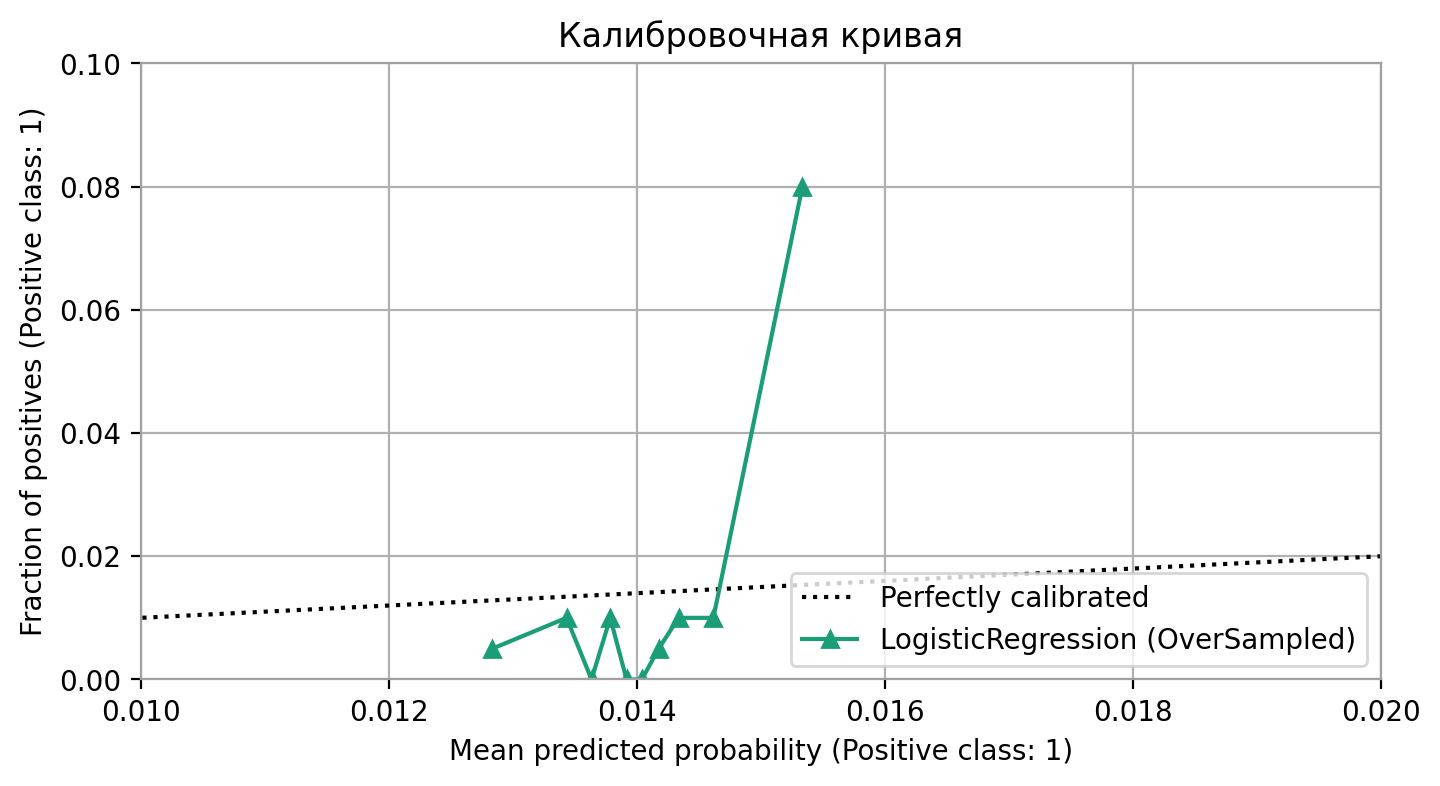

In [88]:
model = LogisticRegressionCV(cv=5)
model.fit(X_train, y_train)

fig, ax = plt.subplots(1, figsize=(8, 4))

CalibrationDisplay.from_estimator(
        model,
        X_test,
        y_test,
        n_bins=10,
        strategy='quantile',
        name="LogisticRegression (OverSampled)",
        ax=ax,
        color=colors(0),
        marker=markers[0],
    )
ax.set_xlim(0.01, 0.02)
ax.set_ylim(0, 0.1)
ax.grid()
ax.set_title("Калибровочная кривая")

Text(0.5, 1.0, 'Калибровочная кривая')

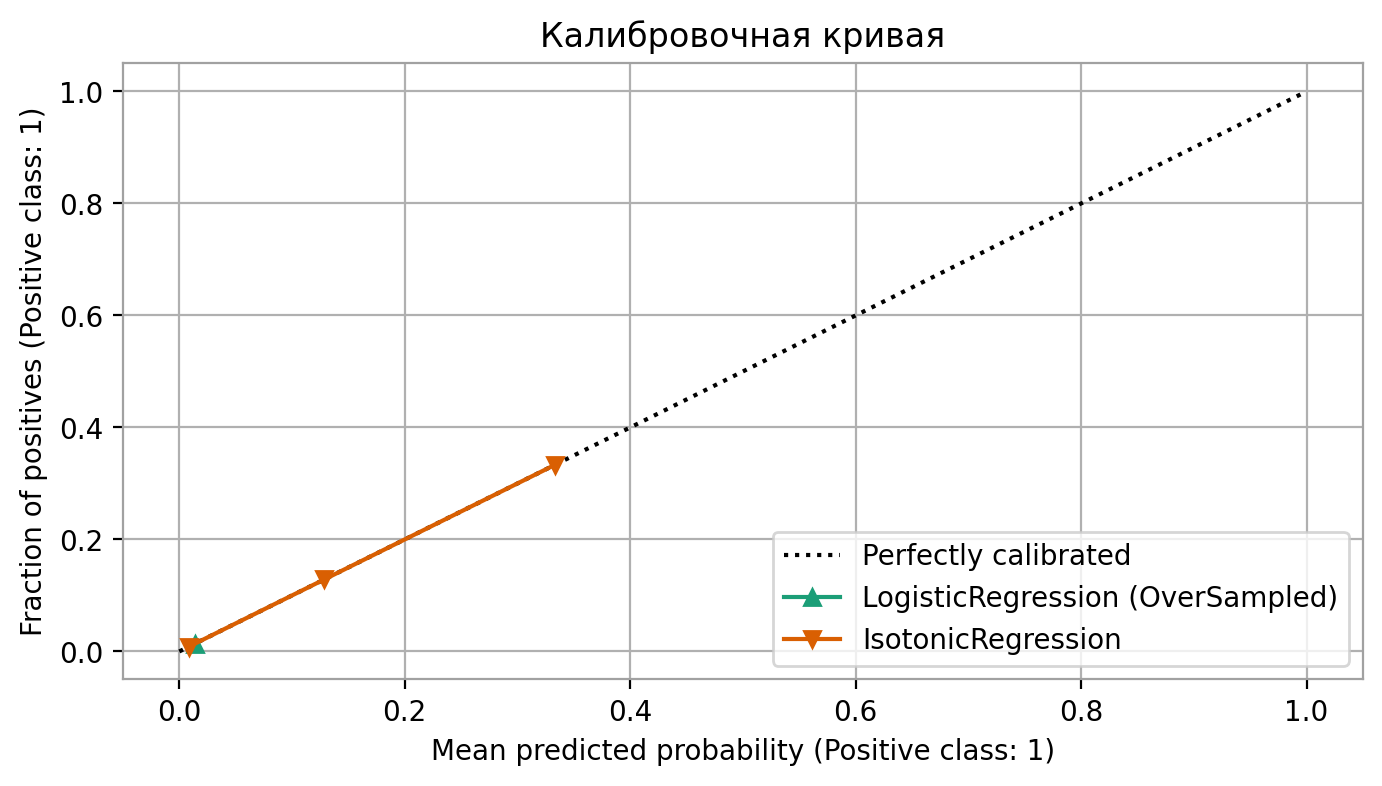

In [89]:
from sklearn.calibration import CalibratedClassifierCV

# model = LogisticRegressionCV(cv=5)
# model.fit(X_train_resampled, y_train_resampled)

# Данные для калибровки
test_proba = model.predict_proba(X_test)

calibrated_clf = CalibratedClassifierCV(model, cv="prefit", method='isotonic')
calibrated_clf.fit(X_test, y_test)

fig, ax = plt.subplots(1, figsize=(8, 4))

CalibrationDisplay.from_estimator(
        model,
        X_test,
        y_test,
        n_bins=10,
        name="LogisticRegression (OverSampled)",
        ax=ax,
        color=colors(0),
        marker=markers[0],
    )

CalibrationDisplay.from_estimator(
        calibrated_clf,
        X_test,
        y_test,
        n_bins=10,
        name="IsotonicRegression",
        ax=ax,
        color=colors(1),
        marker=markers[1],
    )

ax.grid()
ax.set_title("Калибровочная кривая")

### Причина №3. Изменение данных во времени 

С течением времени распределение целевой переменной может меняться.

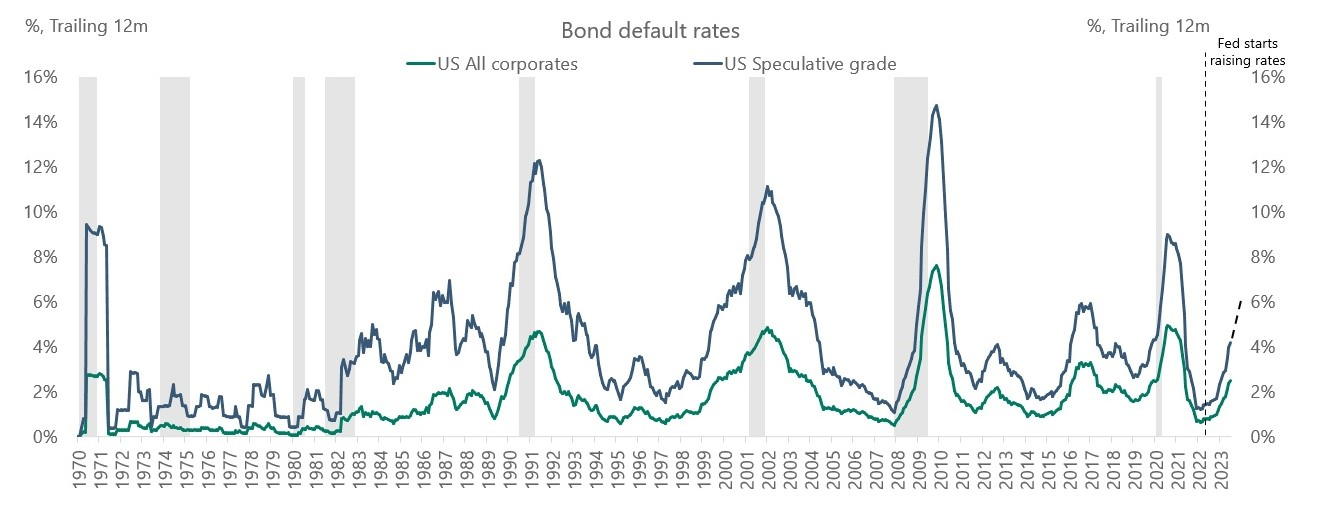

# Методы калибровки

1. Гистограммная калибровка;

2. Изотоническая регрессия;

3. Калибровка Платта;

4. Логистическая регрессия;

5. Деревья калибровки;

6. Ансамблирование;

7. Сглаживание меток;

8. Использование фокальной ошибки и т.д.

## 1. Гистограммная калибровка;

Мы разбиваем отрезок на бины  (одинаковой ширины или равномощные) и хотим на каждом из них предсказывать всегда одну и ту же вероятность:

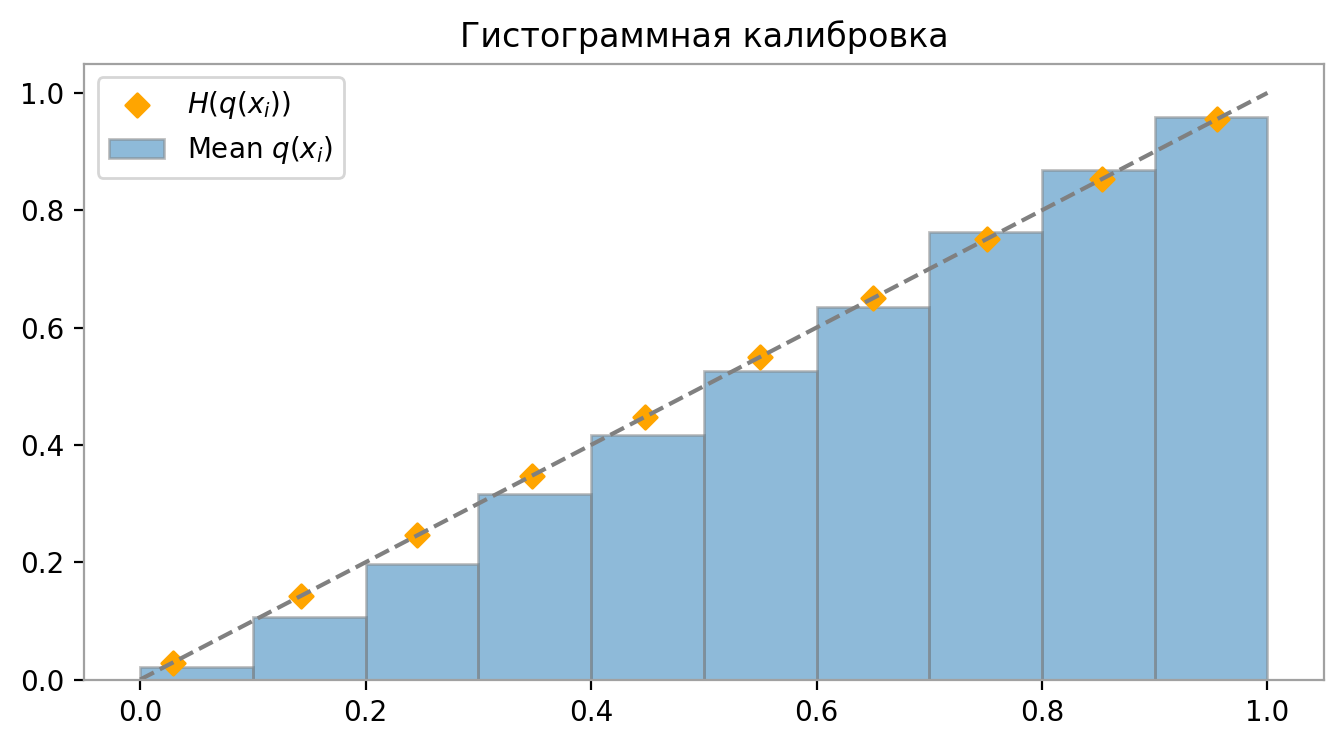

In [44]:
fig, ax = plt.subplots(1, figsize=(8, 4))

## ----------------------------------------------------------------------------------
plt.title("Гистограммная калибровка")
plt.bar([- 0.05 + (0.1 * i) for i in range(1, 11)], 
        prob_true, 
        width=0.1, alpha=0.5, 
        align='center', 
        edgecolor='gray',
        color=None,
        label="Mean $q(x_i)$")
plt.plot([0, 1], [0, 1], c='gray', linestyle="--")
plt.scatter(prob_pred, prob_pred, c='orange', marker="D", label="$H(q(x_i))$")
plt.legend()
plt.show()
# plt.scatter(prob_pred, prob_pred)
## ----------------------------------------------------------------------------------

#### Недостатки

- нужно подбирать границы бакетов
- результирующая вероятность (после калибровки) - дискретная

## 2. Изотоническая регрессия

Изотоническая регрессия минимизирует
$$
\sum\limits_{i=1}^{n}(y_i - g(q(x_i)))^2 \rightarrow \min\limits_g,
$$

где $g(.)$ - кусочно-постоянная функция от $g(x_i)$ - вероятности нашей базовой модели.

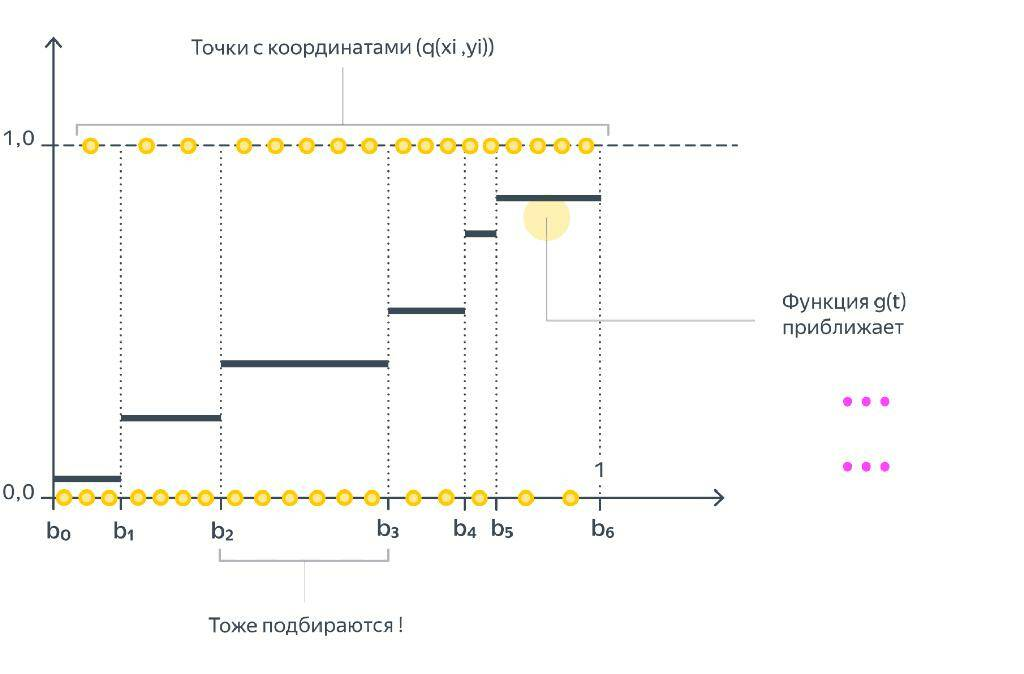

Text(0.5, 1.0, 'Калибровочная кривая')

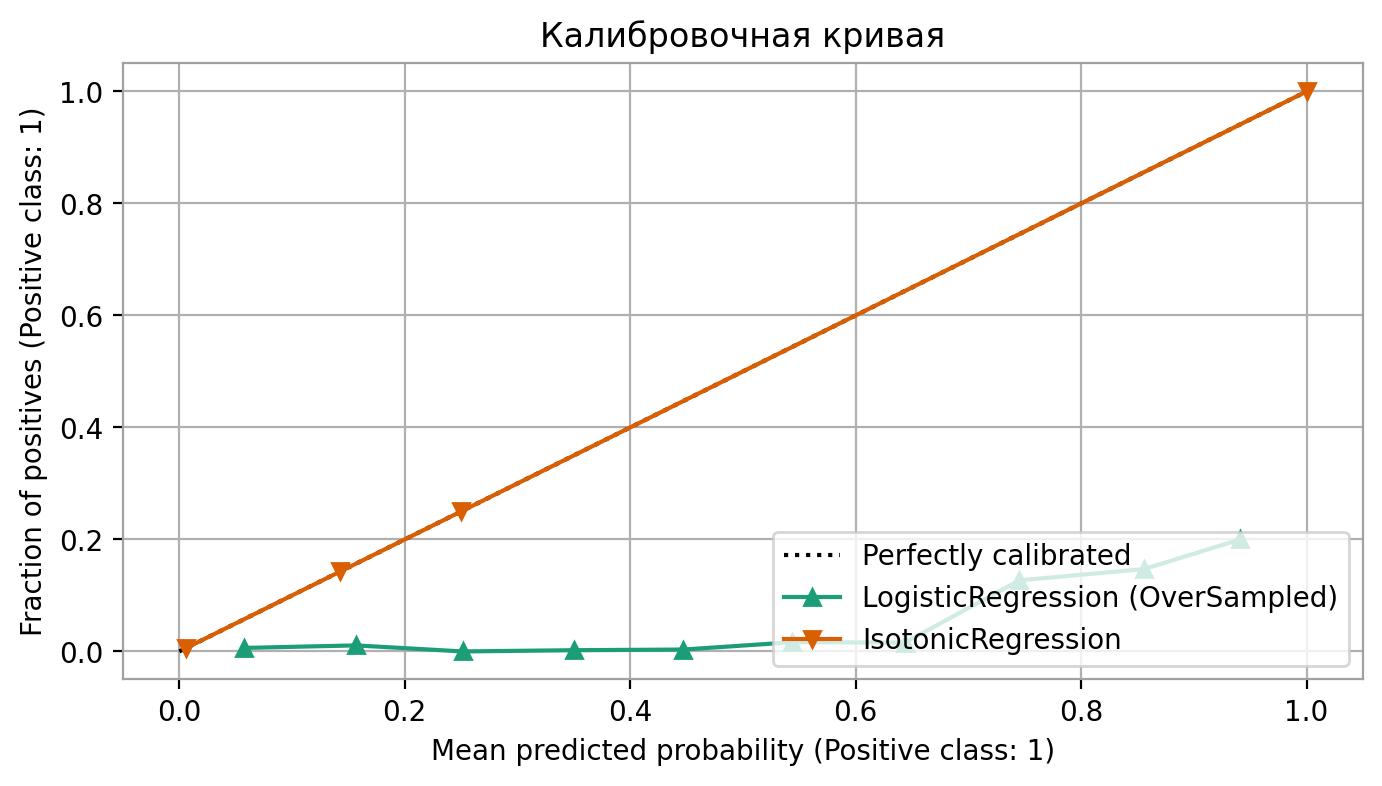

In [90]:
from sklearn.calibration import CalibratedClassifierCV

model = LogisticRegressionCV(cv=5)
model.fit(X_train_resampled, y_train_resampled)

# Данные для калибровки
test_proba = model.predict_proba(X_test)

calibrated_clf_b = CalibratedClassifierCV(model, cv="prefit", method='isotonic')
calibrated_clf_b.fit(X_test, y_test)

fig, ax = plt.subplots(1, figsize=(8, 4))

CalibrationDisplay.from_estimator(
        model,
        X_test,
        y_test,
        n_bins=10,
        name="LogisticRegression (OverSampled)",
        ax=ax,
        color=colors(0),
        marker=markers[0],
    )

CalibrationDisplay.from_estimator(
        calibrated_clf_b,
        X_test,
        y_test,
        n_bins=10,
        name="IsotonicRegression",
        ax=ax,
        color=colors(1),
        marker=markers[1],
    )

ax.grid()
ax.set_title("Калибровочная кривая")

## 3. Калибровка Платта

Калибровка Платта представляет собой по сути применение сигмоиды поверх другой модели (то есть самый наивный способ получения ''вероятностей''). Если $q(x_i)$ – предсказанная вероятность, то мы полагаем

$$
P(y_i=1 | x_i) = \sigma(\alpha q(x_i) + \beta) = \frac{1}{1+e^{-\alpha q(x_i) - \beta}}
$$

где $\alpha$ и $\beta$ подбираются на выборке для калибровки.

Text(0.5, 1.0, 'Калибровочная кривая')

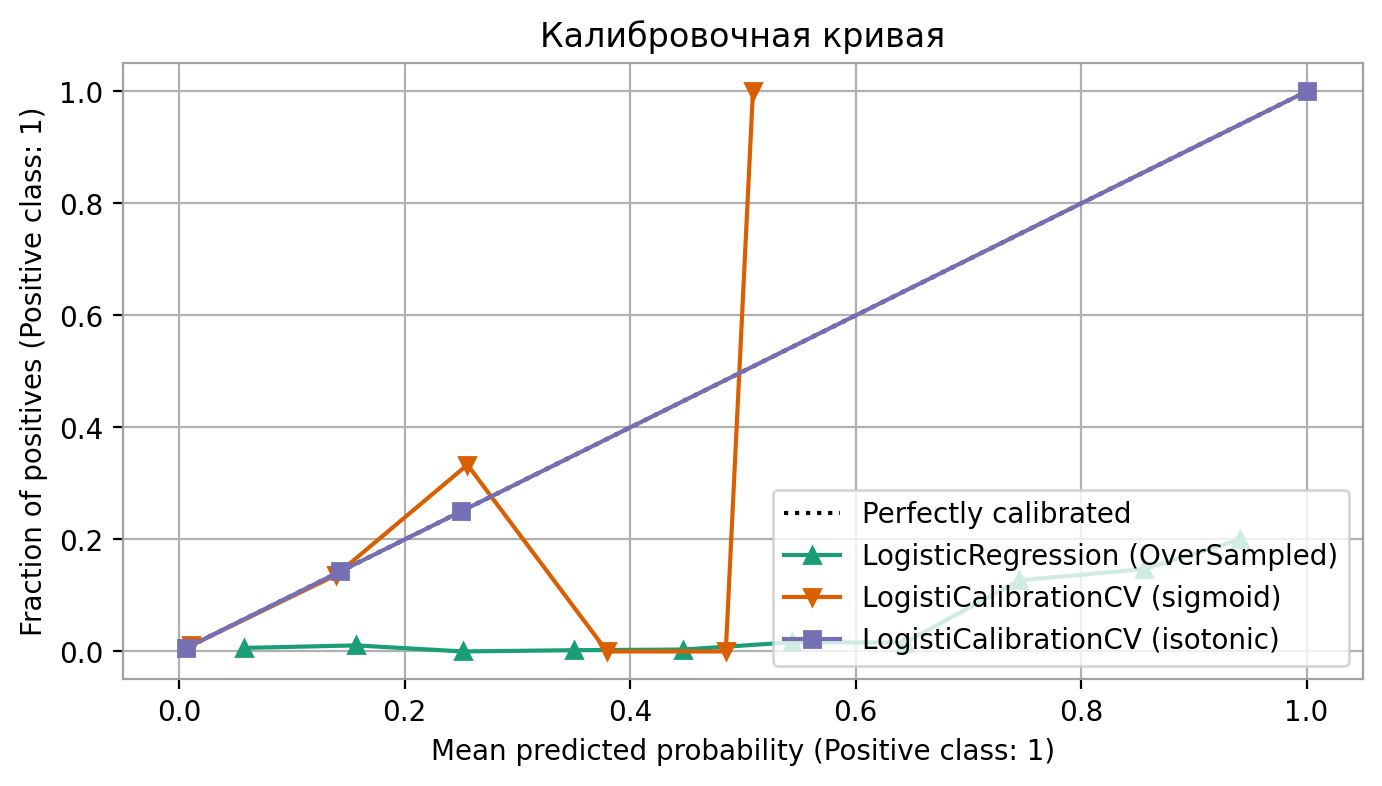

In [92]:
from sklearn.calibration import CalibratedClassifierCV

model = LogisticRegressionCV(cv=5)
model.fit(X_train_resampled, y_train_resampled)

# Данные для калибровки
test_proba = model.predict_proba(X_test)[:, 1]

calibrated_clf_a = CalibratedClassifierCV(model, cv="prefit", method='sigmoid')
calibrated_clf_a.fit(X_test, y_test)

fig, ax = plt.subplots(1, figsize=(8, 4))

CalibrationDisplay.from_estimator(
        model,
        X_test,
        y_test,
        n_bins=10,
        name="LogisticRegression (OverSampled)",
        ax=ax,
        color=colors(0),
        marker=markers[0],
    )

CalibrationDisplay.from_estimator(
        calibrated_clf_a,
        X_test,
        y_test,
        n_bins=10,
        name="LogistiCalibrationCV (sigmoid)",
        ax=ax,
        color=colors(1),
        marker=markers[1],
    )

CalibrationDisplay.from_estimator(
        calibrated_clf_b,
        X_test,
        y_test,
        n_bins=10,
        name="LogistiCalibrationCV (isotonic)",
        ax=ax,
        color=colors(2),
        marker=markers[2],
    )

ax.grid()
ax.set_title("Калибровочная кривая")

# Другие метрики

### 1. Expected/Maximum calibration error

In [64]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
                                y_true=y_test,      # Реальные метки классов
                                y_prob=pred_test,   # Модельная вероятность
                                pos_label=1, 
                                n_bins=10,          # 
                                strategy='uniform'  # или 'quantile' - зависит от распределения вероятности
                            )

`prob_true` - доля класса "1" в каждом бакете

`prob_pred` - средняя модельная вероятность в каждом бакете

In [65]:
def max_calibration_error(prob_true, prob_pred):
    return np.max(np.abs(prob_true - prob_pred))

max_calibration_error(prob_true, prob_pred)

0.049111311851557954

### 2. Brier Loss
Brier Loss измеряет среднеквадратичную разницу между прогнозируемой вероятностью и фактическим результатом. 
$$
BrierLoss = \sum\limits_{i=1}^{n}(y_i - q(x_i))^2
$$
Оценка всегда принимает значение от нуля до единицы, поскольку это максимально возможная разница между прогнозируемой вероятностью (которая должна быть от нуля до единицы) и фактическим результатом (который может принимать значения только 0 и 1)

In [63]:
from sklearn.metrics import brier_score_loss


brier_score_loss(y_test, test_proba)

0.12033626533313672